# Australian Marriage Law Survey Visual Analysis

**According to wikipedia** : The Australian Marriage Law Postal Survey was a national survey designed to gauge support for legalising same-sex marriage in Australia. The survey was held via the postal service between 12 September and 7 November 2017. Unlike voting in elections and referendums, which is compulsory in Australia, responding to the survey was voluntary. 

In this notebook, we analyze the **Australian Marriage Law Postal Survey** by visualizing the data. The data in this file has been cleaned thoroughly to prepare it for analysis.

The notebook that cleans the raw data from scratch is called - **"australian_marriage_law_survey_cleaning"**
   
*Note that this notebook is really part of a greater whole - we visualize results in this notebook, but there is an additional notebook that normalizes the data - and then uses SQLalchemy to import the results into SMSS (microsoft sql server management tool). On top of that, we create an interactive dashboard that looks at the results in Power BI*

***Unfortunately, Much Meaningful analyses cannot be done due to a lack of data at the electorate division level - i.e. (divisions within states). Hence, we do a cursory analysis of the data at the state level. View Wikipedia / other news journals for a more detailed analysis***

***There is a lack of data because the package that hosted the data could not be downloaded, since it has been retired from CRAN. Other troubleshooting methods have not worked so far (such as the one suggested by GPT)***

![My Image](eechidna_failure.png)

In [13]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [14]:
# Read in the data
df_part = pd.read_csv('aus_participation.csv')
df_part_gend = pd.read_csv('aus_participation_gendered.csv')
df_response = pd.read_csv('aus_response.csv')

## Visualizing the Summary Statistics

    * We first identify the largest states within Australia, to narrow down our analysis
    
    * New South Wales, Queensland, and Victoria have the largest number of votes, which far exceed any other state
    

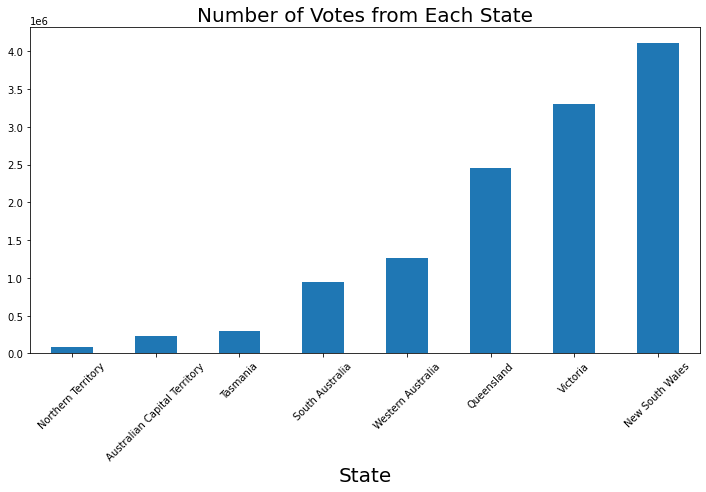

In [37]:
plot = df_response.groupby('State')['vote_total_qty'].sum().sort_values().plot(kind='bar', figsize=(12,6))
plot.tick_params(axis='x', rotation=45)
plt.xlabel('State', fontsize = 20)
plt.title('Number of Votes from Each State', fontsize = 20)
plt.show()

## Visualizing the Net contribution per state

    * To get a visual indication of the effect each state had in contributing to the final outcome, we plot a waterfall chart
    
    * Despite its massive size, New South Wales has only a comparable net effect to Queensland and is lower than Victoria's
    
    * As for the other states, the difference in size of states makes it hard to compare each state with the others

In [125]:
df_response2 = df_response.copy()
df_response2['net_vote'] = df_response['vote_yes_pct'] - df_response['vote_no_pct']

# Run only once
water_fall = df_response2.groupby('State')['net_vote'].sum().sort_values(ascending=False)
water_fall = water_fall.astype(int)
water_fall['Total'] = water_fall.sum()

In [126]:
water_fall2 = water_fall.to_frame().reset_index()
fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ['relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'relative', 'relative','total'],
    x = water_fall2['State'],
    textposition = "outside",
    text = water_fall2['net_vote'],
    y = water_fall2['net_vote'],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))
fig.update_layout(
        title = "Ranking Net Effect of Votes by State",
        showlegend = False
)
fig.show()

## Due to the immense size difference between states, we choose to focus on New South Wales, Queensland, and Victoria

In [39]:
# Filter the data frame for the 3 main states
mainstates_response = df_response[df_response['State'].isin(['New South Wales', 'Queensland', 'Victoria'])]

total_votes = df_response['vote_total_qty'].sum()
print(f'the total number of votes in the whole of Australia is {total_votes}')

mainstate_votes = mainstates_response['vote_total_qty'].sum()
pct = round((mainstate_votes / total_votes) * 100,2)
print(f'the total number of votes in the three states is {mainstate_votes}, which is {pct}% of the total votes')

the total number of votes in the whole of Australia is 12691234.0
the total number of votes in the three states is 9866002.0, which is 77.74% of the total votes


## Discovering Differences in Approval Rates across States

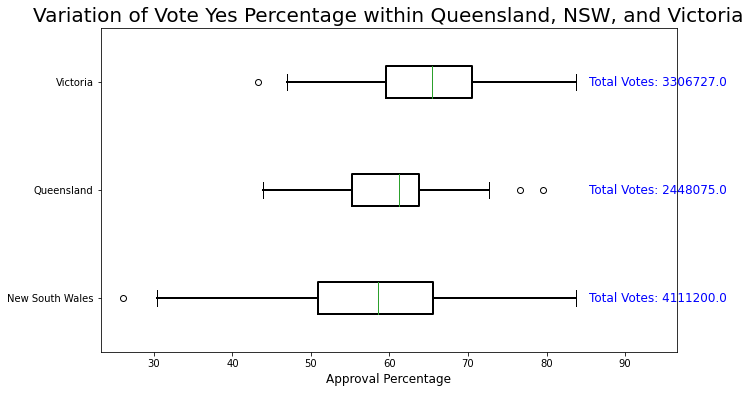

In [41]:
# Group data by 'state' and then create a box plot
ax = mainstates_response.boxplot(column='vote_yes_pct', 
                         by='State', 
                         vert=False, 
                         figsize=(10, 6),
                         boxprops=dict(linestyle='-', linewidth=2, color='black'), 
                         whiskerprops=dict(linestyle='-', linewidth=2, color='black'))
ax.grid(False)

plt.ylabel('')
plt.title('Variation of Vote Yes Percentage within Queensland, NSW, and Victoria', fontsize = 20)
plt.suptitle('')  # Remove the automatic 'Boxplot grouped by state' title
plt.xlabel('Approval Percentage', fontsize = 12)

# Extend the x-axis limits to make room for annotations
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 10)
total_votes_per_state = mainstates_response.groupby('State')['vote_total_qty'].sum()

# Annotate each boxplot with the total number of votes, positioned to the right of the plot
for i, (state, total_votes) in enumerate(total_votes_per_state.items(), start=1):
    ax.annotate(f'Total Votes: {total_votes}', xy=(1, i), xycoords=('axes fraction', 'data'),
                xytext=(50, 0), textcoords='offset points',  # Adjust xytext for positioning
                va='center', ha='right', fontsize=12, color='blue')

plt.show()

## Understanding What affects Approval Variation across States


### Demographic Mix within NSW, Queensland, and Victoria in 2016 and its relationship with survey results

    * The Australian Bureau of Statistics offers data on its demographics in the year 2017 for different States
    
    * The premise of this section is to analyze the demographics of the States, and analyze their effect on Approval Rates
    
    * It is possible that more senior folk might hold on to conservative views as compared to their younger peers
    
### Conclusion : 

    * Demographics do not explain the variation in Approval. Our plot shows that the demographics across the 3 states are not materially different

In [85]:
mainstates_part = df_part[df_part['State'].isin(['New South Wales', 'Queensland', 'Victoria'])]

# Get the demographic Data that we want
demographic_df = mainstates_part[mainstates_part['statistic']=='Total participants'].groupby(['State', 'age_category'])['quantity'].sum()
demographic_df = demographic_df.reset_index()

# Split this dataframe into 3 seperate dataframes
NSW_demo = demographic_df[demographic_df['State'] == 'New South Wales'][['age_category', 'quantity']]
queens_demo = demographic_df[demographic_df['State'] == 'Queensland'][['age_category', 'quantity']]
vict_demo = demographic_df[demographic_df['State'] == 'Victoria'][['age_category', 'quantity']]

# Calculate the demographic split across all states
lst = [NSW_demo, queens_demo, vict_demo]
for df in lst:
    max_pop = df[df['age_category']=='Total Persons']['quantity'].values
    df['proportion'] = round(df['quantity'] / max_pop, 4)
    # df = df.drop(df.index[-1])
    
NSW_demo = NSW_demo.drop(NSW_demo.index[-1])
queens_demo = queens_demo.drop(queens_demo.index[-1])
vict_demo = vict_demo.drop(vict_demo.index[-1])

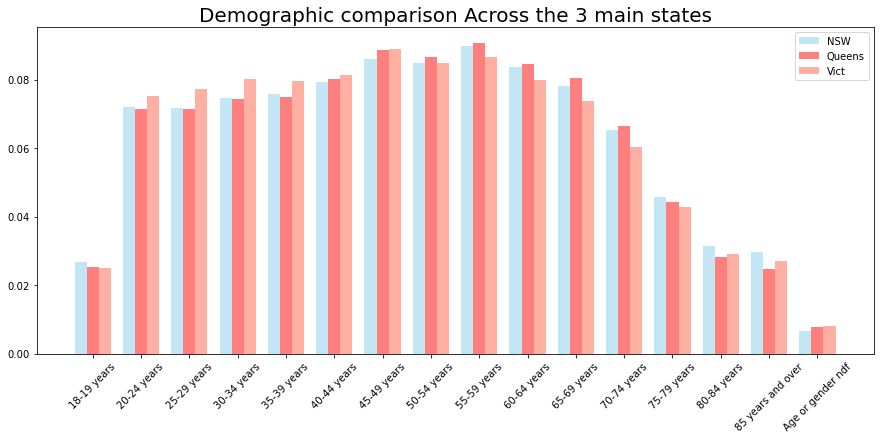

In [90]:
positions = list(range(len(NSW_demo['age_category'])))
width = 0.25
plt.figure(figsize=(15, 6))

# Plotting each series
plt.bar([p - width for p in positions], NSW_demo['proportion'], width, alpha=0.5, color='skyblue',label='NSW')
plt.bar(positions, queens_demo['proportion'], width, alpha=0.5, color='red', label='Queens')
plt.bar([p + width for p in positions], vict_demo['proportion'], width, alpha=0.5, color='tomato',label='Vict')

# Adding the legend and labels
plt.title('Demographic comparison Across the 3 main states', fontsize=20)
plt.xticks(positions, NSW_demo['age_category'], rotation=45)

# Add a legend
plt.legend()
plt.show()

### More Demographic Statistics : Religion

One of the factors affecting the Western transition towards LGBTQ acceptance / instituitionalization might be the persistence of religious beliefs which shun homosexuality
    
Two notable religions come to mind : Christianity(incl Catholicism) & Islam
    
In truth, this is actually a well known fact : **Data from ABS census has revealed that no_votes are correlated with %christians, %islam, in electorate divisions, and negatively correlated with %no_religion**

![My Image](religion_approval_rate.png)

While we would like to plot the data using a scatter plot of 150 points to identify relationships within the scatterplot, **we do not have access to ABS religion data by electorate division** - the only known library that provides access to the data is a retired R-package called `eechidna`

### We will settle for State level Data to observe whether any trends exist

In [122]:
df_religion = pd.read_excel('demographics_religion_by_state.xlsx', sheet_name='Data')

In [123]:
df_state_aggregates = df_response.groupby('State')[['vote_yes_qty','vote_total_qty']].sum().reset_index()
df_state_aggregates['approval_rate'] = round(df_state_aggregates['vote_yes_qty'] / df_state_aggregates['vote_total_qty'],2)*100
df_state_aggregates

df_christianity_approval_corr = pd.merge(df_religion[df_religion['Religion'] == 'Christianity'].copy().reset_index(), 
                                         df_state_aggregates, on='State')[['State', 'Proportion', 'approval_rate']]

df_islam_approval_corr = pd.merge(df_religion[df_religion['Religion'] == 'Islam'].copy().reset_index(), 
                                         df_state_aggregates, on='State')[['State', 'Proportion', 'approval_rate']]

df_noreligion_approval_corr = pd.merge(df_religion[df_religion['Religion'] == 'No Religion, so described'].copy().reset_index(), 
                                         df_state_aggregates, on='State')[['State', 'Proportion', 'approval_rate']]

### Finding :

It appears as though - at the state level - the trend is very obvious for Christianity and "No religion"

However, we see that the trend is not that obvious for the Muslim Religion

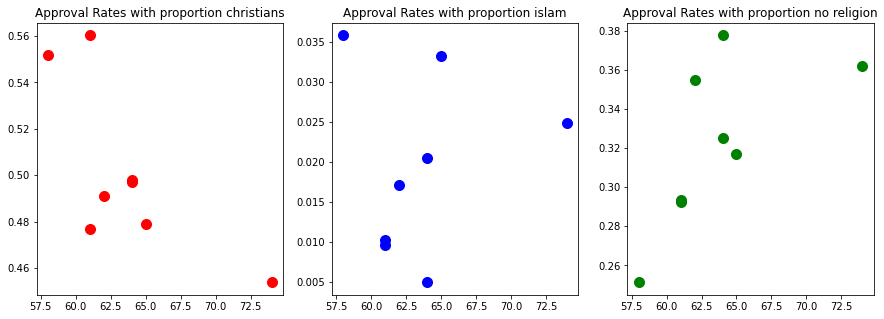

In [124]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

axs[0].scatter(df_christianity_approval_corr['approval_rate'],
               df_christianity_approval_corr['Proportion'],
               s=100,color='red')
axs[0].set_title('Approval Rates with proportion christians')

axs[1].scatter(df_islam_approval_corr['approval_rate'],
               df_islam_approval_corr['Proportion'],
               s=100,color='blue')
axs[1].set_title('Approval Rates with proportion islam')

axs[2].scatter(df_noreligion_approval_corr['approval_rate'],
               df_noreligion_approval_corr['Proportion'],
               s=100,color='green')
axs[2].set_title('Approval Rates with proportion no religion')

plt.show()